### Included

* Data prep (cleaning, scaling)
* Linear, Ridge, Lasso Regression
* Random Forest (and with Grid Search)
* MLP (with Grid Search)

### To do

* Add Airbnb data
* Add Clustering data

## Setup

In [1]:
import numpy as np
import sklearn as sk
import pandas as pd

print('Numpy: ', np.__version__) #1.16.2
print('Sklearn: ', sk.__version__) # 0.19.1
print('Pandas: ', pd.__version__) # 0.24.2

Numpy:  1.16.2
Sklearn:  0.19.1
Pandas:  0.24.2


In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, LogisticRegression
from sklearn.metrics import classification_report, mean_squared_error, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor, MLPClassifier
from matplotlib import pyplot as plt
import xgboost as xgb

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Import Data

In [3]:
df = pd.read_csv('merged2.csv', header=None)

In [4]:
df.drop(columns=[0], inplace=True)

In [5]:
df.columns = ['ID', 'PropertyFullStreetAddress', 'PropertyAddressUnitNumber',
       'PropertyCity', 'County', 'PropertyZip', 'PropertyAddressLatitude',
       'PropertyAddressLongitude', 'BuildingAreaSqFt', 'LotSizeSquareFeet',
       'FireplaceNumber', 'YearBuilt', 'NoOfStories', 'TotalBedrooms',
       'NormalizedBathCount', 'LandAssessedValue', 'ImprovementAssessedValue',
       'TotalAssessedValue', 'GarageNoOfCars', 'NormalizedListPrice',
       'ListDate', 'NormalizedSalePrice', 'SoldDate', 'ListYearMonth',
       'SoldYearMonth', 'MonthsToSale', 'NormalizedSalesPremium',
       'built_prct']

In [6]:
# Log Sales Price
df['LogSalePrice'] = np.log(df['NormalizedSalePrice'])

In [7]:
# Exclude 'NormalizedListPrice' because it may be too correlated with target 'NormalizedSalePrice'
target = ['NormalizedSalePrice']
numeric_cols = ['BuildingAreaSqFt', 'LotSizeSquareFeet', 'NoOfStories', 'TotalBedrooms', 
                'NormalizedBathCount', 'LandAssessedValue', 'ImprovementAssessedValue', 'TotalAssessedValue', 
                'GarageNoOfCars', 'PropertyAddressLatitude', 'PropertyAddressLongitude',
                'built_prct', 'MonthsToSale', 'NormalizedSalesPremium'
               ]
categorical_cols = ['PropertyZip', 'YearBuilt', 'ListYearMonth']

In [8]:
df_noNA = df[target + numeric_cols + categorical_cols  + ['LogSalePrice', 'NormalizedListPrice']].dropna()

## Helper functions

In [9]:
def get_adjusted_r2(model, X, y):
    r2 = model.score(X, y)
    n = X.shape[0]
    p = X.shape[1]
    
    adj_r2 = r2 - (1 - r2)*(p/(n-p-1))
    return adj_r2

In [10]:
def get_mape(y_true, y_pred):
    abs_errors = [np.abs((y_true-y_pred)/y_true) for y_true,y_pred in zip(y_true,y_pred)]
    mape = (sum(abs_errors)/len(abs_errors)) * 100
    return mape

In [11]:
def get_mdape(y_true, y_pred):
    abs_errors = [np.abs((y_true-y_pred)/y_true) for y_true,y_pred in zip(y_true,y_pred)]
    mdape = np.median(abs_errors) * 100
    return mdape

# Regression

## Linear Regression

### Create dataset for Linear Regression

In [12]:
# Create numeric and categorical columns
df_num = df_noNA[numeric_cols]
df_cat = df_noNA[categorical_cols]
df_target  = df_noNA['NormalizedSalePrice']

# Create dummy variables for categorical columns
for column in categorical_cols:
    df_cat[column] = df_cat[column].astype("category")
df_cat = pd.get_dummies(df_cat)

df_reg = pd.concat([df_num, df_cat, df_target, df_noNA[['LogSalePrice', 'NormalizedListPrice']]], axis=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
# Train/test split
train_reg, test_reg = train_test_split(df_reg, random_state=1)
train_reg, val_reg = train_test_split(train_reg, random_state=1)

In [14]:
# Scale numeric features
column_means_std = {}
for numeric_column in numeric_cols:
    means = train_reg[numeric_column].mean()
    std = train_reg[numeric_column].std()
    column_means_std[numeric_column] = [means, std]

def get_z_scores(df, columns):
    for column in columns:
        df[column] = (df[column] - column_means_std[column][0])/column_means_std[column][1]
        
get_z_scores(train_reg, numeric_cols)
get_z_scores(val_reg, numeric_cols)
get_z_scores(test_reg, numeric_cols)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [15]:
listPriceReg_train = train_reg.pop('NormalizedListPrice').reset_index().drop(columns = ['index'])
listPriceReg_val = val_reg.pop('NormalizedListPrice').reset_index().drop(columns = ['index'])
listPriceReg_test = test_reg.pop('NormalizedListPrice').reset_index().drop(columns = ['index'])

salePriceReg_train = train_reg.pop('NormalizedSalePrice').reset_index().drop(columns = ['index'])
salePriceReg_val = val_reg.pop('NormalizedSalePrice').reset_index().drop(columns = ['index'])
salePriceReg_test = test_reg.pop('NormalizedSalePrice').reset_index().drop(columns = ['index'])

In [16]:
train_reg_X = train_reg.drop(columns = ['LogSalePrice','MonthsToSale']).reset_index().drop(columns = ['index'])
train_reg_y = train_reg['LogSalePrice'].reset_index().drop(columns = ['index'])
val_reg_X = val_reg.drop(columns = ['LogSalePrice','MonthsToSale']).reset_index().drop(columns = ['index'])
val_reg_y = val_reg['LogSalePrice'].reset_index().drop(columns = ['index'])
test_reg_X = test_reg.drop(columns = ['LogSalePrice','MonthsToSale']).reset_index().drop(columns = ['index'])
test_reg_y = test_reg['LogSalePrice'].reset_index().drop(columns = ['index'])

### Run Linear Regression on Train and Val set 

In [17]:
LR = LinearRegression()
LR.fit(train_reg_X, train_reg_y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
print('Train R-squared: {:.3}'.format(LR.score(train_reg_X, train_reg_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(LR, train_reg_X, train_reg_y)))

print('Val R-squared: {:.3}'.format(LR.score(val_reg_X, val_reg_y)))
print('Val Adjusted R-squared: {:.3}'.format(get_adjusted_r2(LR, val_reg_X, val_reg_y)))

print('Test R-squared: {:.3}'.format(LR.score(test_reg_X, test_reg_y)))
print('Test Adjusted R-squared: {:.3}'.format(get_adjusted_r2(LR, test_reg_X, test_reg_y)))

Train R-squared: 0.896
Train Adjusted R-squared: 0.895
Val R-squared: 0.873
Val Adjusted R-squared: 0.868
Test R-squared: 0.883
Test Adjusted R-squared: 0.88


In [19]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in LR.predict(train_reg_X)])))
print('Val MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_val['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in LR.predict(val_reg_X)])))
print('Test MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in LR.predict(test_reg_X)])))


Train MAE: 126490.01801794177
Val MAE: 250795.11814631656
Test MAE: 100779.71450035712


In [20]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in LR.predict(train_reg_X)])))
print('Val MAPE: {}'.format(get_mape(y_true = salePriceReg_val['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in LR.predict(val_reg_X)])))
print('Test MAPE: {}'.format(get_mape(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in LR.predict(test_reg_X)])))


Train MAPE: [12.82818381]
Val MAPE: [15.08802124]
Test MAPE: [13.2988422]


In [21]:
LR_coefficients = pd.DataFrame([train_reg_X.columns, LR.coef_[0]]).T

In [22]:
LR_coefficients.sort_values(1, ascending=False).head(10)

,0,1
62,YearBuilt_1910.0,1.31741
57,YearBuilt_1882.0,1.28725
69,YearBuilt_1918.0,0.551044
66,YearBuilt_1915.0,0.550899
15,PropertyZip_78703.0,0.528475
58,YearBuilt_1900.0,0.488385
17,PropertyZip_78705.0,0.457258
16,PropertyZip_78704.0,0.420431
78,YearBuilt_1927.0,0.339059
48,PropertyZip_78751.0,0.337198


### Ridge regression

In [23]:
reg_RidgeCV = RidgeCV(cv=10)
reg_RidgeCV.fit(train_reg_X, train_reg_y)

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=10, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [24]:
print('Train R-squared: {:.3}'.format(reg_RidgeCV.score(train_reg_X, train_reg_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(reg_RidgeCV, train_reg_X, train_reg_y)))

print('Val R-squared: {:.3}'.format(reg_RidgeCV.score(val_reg_X, val_reg_y)))
print('Val Adjusted R-squared: {:.3}'.format(get_adjusted_r2(reg_RidgeCV, val_reg_X, val_reg_y)))

print('Test R-squared: {:.3}'.format(reg_RidgeCV.score(test_reg_X, test_reg_y)))
print('Test Adjusted R-squared: {:.3}'.format(get_adjusted_r2(reg_RidgeCV, test_reg_X, test_reg_y)))

Train R-squared: 0.894
Train Adjusted R-squared: 0.893
Val R-squared: 0.874
Val Adjusted R-squared: 0.869
Test R-squared: 0.886
Test Adjusted R-squared: 0.883


In [25]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = [i for i in salePriceReg_train['NormalizedSalePrice']], y_pred = [max(np.exp(i)[0],0) for i in reg_RidgeCV.predict(train_reg_X)])))
print('Val MAE: {}'.format(mean_absolute_error(y_true = [i for i in salePriceReg_val['NormalizedSalePrice']], y_pred = [max(np.exp(i)[0],0) for i in reg_RidgeCV.predict(val_reg_X)])))
print('Test MAE: {}'.format(mean_absolute_error(y_true = [i for i in salePriceReg_test['NormalizedSalePrice']], y_pred = [max(np.exp(i)[0],0) for i in reg_RidgeCV.predict(test_reg_X)])))


Train MAE: 145641.81881967245
Val MAE: 258307.65336086458
Test MAE: 100849.11238132621


In [26]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in reg_RidgeCV.predict(train_reg_X)])))
print('Val MAPE: {}'.format(get_mape(y_true = salePriceReg_val['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in reg_RidgeCV.predict(val_reg_X)])))
print('Test MAPE: {}'.format(get_mape(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in reg_RidgeCV.predict(test_reg_X)])))


Train MAPE: [13.01630627]
Val MAPE: [15.1305344]
Test MAPE: [13.19548038]


In [27]:
Ridge_coefficients = pd.DataFrame([train_reg_X.columns, reg_RidgeCV.coef_[0]]).T

Top 10 positive features

In [28]:
Ridge_coefficients.sort_values(by=1, ascending=False).head(10)

,0,1
15,PropertyZip_78703.0,0.49476
16,PropertyZip_78704.0,0.408075
17,PropertyZip_78705.0,0.361981
48,PropertyZip_78751.0,0.307873
43,PropertyZip_78746.0,0.297105
52,PropertyZip_78756.0,0.291152
30,PropertyZip_78731.0,0.280626
14,PropertyZip_78702.0,0.268107
21,PropertyZip_78722.0,0.240167
62,YearBuilt_1910.0,0.234493


Top 10 negative features

In [29]:
Ridge_coefficients.sort_values(by=1, ascending=True).head(10)

,0,1
41,PropertyZip_78744.0,-0.333913
19,PropertyZip_78719.0,-0.307835
44,PropertyZip_78747.0,-0.285578
24,PropertyZip_78725.0,-0.268902
51,PropertyZip_78754.0,-0.258191
45,PropertyZip_78748.0,-0.219171
23,PropertyZip_78724.0,-0.212823
50,PropertyZip_78753.0,-0.207925
33,PropertyZip_78734.0,-0.186811
27,PropertyZip_78728.0,-0.180974


### Lasso Regression

In [30]:
reg_LassoCV = LassoCV(cv=10)
reg_LassoCV.fit(train_reg_X, train_reg_y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [31]:
print('Train R-squared: {:.3}'.format(reg_LassoCV.score(train_reg_X, train_reg_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(reg_LassoCV, train_reg_X, train_reg_y)))

print('Val R-squared: {:.3}'.format(reg_LassoCV.score(val_reg_X, val_reg_y)))
print('Val Adjusted R-squared: {:.3}'.format(get_adjusted_r2(reg_LassoCV, val_reg_X, val_reg_y)))

print('Test R-squared: {:.3}'.format(reg_LassoCV.score(test_reg_X, test_reg_y)))
print('Test Adjusted R-squared: {:.3}'.format(get_adjusted_r2(reg_LassoCV, test_reg_X, test_reg_y)))

Train R-squared: 0.887
Train Adjusted R-squared: 0.885
Val R-squared: 0.869
Val Adjusted R-squared: 0.863
Test R-squared: 0.882
Test Adjusted R-squared: 0.878


In [32]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in reg_LassoCV.predict(train_reg_X)])))
print('Val MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_val['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in reg_LassoCV.predict(val_reg_X)])))
print('Test MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in reg_LassoCV.predict(test_reg_X)])))


Train MAE: 193342.29816446913
Val MAE: 275366.4410799308
Test MAE: 104976.02313217708


In [33]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in reg_LassoCV.predict(train_reg_X)])))
print('Val MAPE: {}'.format(get_mape(y_true = salePriceReg_val['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in reg_LassoCV.predict(val_reg_X)])))
print('Test MAPE: {}'.format(get_mape(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in reg_LassoCV.predict(test_reg_X)])))


Train MAPE: 13.844224630011404
Val MAPE: 15.614956724300077
Test MAPE: 13.516682590579673


Top 10 positive features

In [34]:
Lasso_coefficients = pd.DataFrame([train_reg_X.columns, reg_LassoCV.coef_]).T

In [35]:
Lasso_coefficients.sort_values(by=1, ascending=False).head(10)

,0,1
15,PropertyZip_78703.0,0.525624
16,PropertyZip_78704.0,0.443029
48,PropertyZip_78751.0,0.334299
52,PropertyZip_78756.0,0.315503
17,PropertyZip_78705.0,0.309331
43,PropertyZip_78746.0,0.303621
30,PropertyZip_78731.0,0.302143
14,PropertyZip_78702.0,0.294463
53,PropertyZip_78757.0,0.26027
21,PropertyZip_78722.0,0.2347


Top 10 negative features

In [36]:
Lasso_coefficients.sort_values(by=1, ascending=True).head(10)

,0,1
41,PropertyZip_78744.0,-0.303033
44,PropertyZip_78747.0,-0.246604
24,PropertyZip_78725.0,-0.240769
51,PropertyZip_78754.0,-0.22348
23,PropertyZip_78724.0,-0.178862
45,PropertyZip_78748.0,-0.174026
50,PropertyZip_78753.0,-0.166571
27,PropertyZip_78728.0,-0.123889
54,PropertyZip_78758.0,-0.107283
192,ListYearMonth_2015-01,-0.080632


## Random Forest

### Run Random Forest Regressor on Train and Val set 

In [37]:
RF = RandomForestRegressor()
RF.fit(train_reg_X, train_reg_y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [38]:
print('Train R-squared: {:.3}'.format(RF.score(train_reg_X, train_reg_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(RF, train_reg_X, train_reg_y)))

print('Val R-squared: {:.3}'.format(RF.score(val_reg_X, val_reg_y)))
print('Val Adjusted R-squared: {:.3}'.format(get_adjusted_r2(RF, val_reg_X, val_reg_y)))

print('Test R-squared: {:.3}'.format(RF.score(test_reg_X, test_reg_y)))
print('Test Adjusted R-squared: {:.3}'.format(get_adjusted_r2(RF, test_reg_X, test_reg_y)))

Train R-squared: 0.986
Train Adjusted R-squared: 0.986
Val R-squared: 0.923
Val Adjusted R-squared: 0.92
Test R-squared: 0.914
Test Adjusted R-squared: 0.912


In [39]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = train_reg_y, y_pred = [max(np.exp(i),0) for i in RF.predict(train_reg_X)])))
print('Val MAE: {}'.format(mean_absolute_error(y_true = val_reg_y, y_pred = [max(np.exp(i),0) for i in RF.predict(val_reg_X)])))
print('Test MAE: {}'.format(mean_absolute_error(y_true = test_reg_y, y_pred = [max(np.exp(i),0) for i in RF.predict(test_reg_X)])))


Train MAE: 472228.7287562554
Val MAE: 466724.65950641764
Test MAE: 472300.59128351125


In [40]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in RF.predict(train_reg_X)])))
print('Val MAPE: {}'.format(get_mape(y_true = salePriceReg_val['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in RF.predict(val_reg_X)])))
print('Test MAPE: {}'.format(get_mape(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in RF.predict(test_reg_X)])))


Train MAPE: 4.0484580539713395
Val MAPE: 10.104251802687973
Test MAPE: 10.55014891923538


In [41]:
print('Train MdAPE: {}'.format(get_mdape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in RF.predict(train_reg_X)])))
print('Val MdAPE: {}'.format(get_mdape(y_true = salePriceReg_val['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in RF.predict(val_reg_X)])))
print('Test MdAPE: {}'.format(get_mdape(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in RF.predict(test_reg_X)])))


Train MdAPE: 2.63556510450791
Val MdAPE: 6.872047559513129
Test MdAPE: 7.234842363102628


### With Grid Search

In [340]:
rfr = RandomForestRegressor()

In [346]:
parameters_rfr = {'n_estimators':[300],
                  'min_samples_split':range(2,5),
                  'max_depth':range(12,7,-1)
                 }

In [347]:
search_rfr = GridSearchCV(rfr, parameters_rfr, verbose=5, n_jobs=-1)

In [348]:
### Don't rerun unless data has changed

search_rfr.fit(train_reg_X, train_reg_y)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] max_depth=12, min_samples_split=2, n_estimators=300 .............
[CV] max_depth=12, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=12, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=12, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=12, min_samples_split=3, n_estimators=300 .............
[CV] max_depth=12, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=12, min_samples_split=4, n_estimators=300 .............
[CV] max_depth=12, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

[CV]  max_depth=12, min_samples_split=4, n_estimators=300, score=0.9183777157106086, total= 1.9min
[CV] max_depth=12, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=2, n_estimators=300, score=0.9184879205381411, total= 1.9min
[CV] max_depth=11, min_samples_split=2, n_estimators=300 .............
[CV]  max_depth=12, min_samples_split=3, n_estimators=300, score=0.9184176104287679, total= 1.9min
[CV] max_depth=11, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.9min
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=3, n_estimators=300, score=0.9196625861646543, total= 1.9min
[CV] max_depth=11, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=3, n_estimators=300, score=0.9182078602904148, total= 1.9min
[CV] max_depth=11, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=2, n_estimators=300, score=0.9181846854114741, total= 1.9min
[CV] max_depth=11, min_samples_split=3, n_estimators=300 .............
[CV]  max_depth=12, min_samples_split=4, n_estimators=300, score=0.9197095851111511, total= 1.9min
[CV] max_depth=11, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=2, n_estimators=300, score=0.9196324381378648, total= 1.9min
[CV] max_depth=11, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=2, n_estimators=300, score=0.9169863870443458, total= 1.7min
[CV] max_depth=11, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=3, n_estimators=300, score=0.9169691834971151, total= 1.7min
[CV] max_depth=11, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=3, n_estimators=300, score=0.9169466756541775, total= 1.7min
[CV] max_depth=10, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=2, n_estimators=300, score=0.9182214944338172, total= 1.7min
[CV] max_depth=10, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=2, n_estimators=300, score=0.9170099801711796, total= 1.7min
[CV] max_depth=10, min_samples_split=2, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=3, n_estimators=300, score=0.9182813867461875, total= 1.7min
[CV] max_depth=10, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=4, n_estimators=300, score=0.9183218695198417, total= 1.7min
[CV] max_depth=10, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=12, min_samples_split=4, n_estimators=300, score=0.9182644115237014, total= 1.9min
[CV] max_depth=10, min_samples_split=3, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=2, n_estimators=300, score=0.9155188940884822, total= 1.6min
[CV] max_depth=10, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=3, n_estimators=300, score=0.9163518029221424, total= 1.6min
[CV]  max_depth=10, min_samples_split=2, n_estimators=300, score=0.9154354719387886, total= 1.6min
[CV] max_depth=10, min_samples_split=4, n_estimators=300 .............
[CV] max_depth=10, min_samples_split=4, n_estimators=300 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=2, n_estimators=300, score=0.916293783658808, total= 1.6min
[CV] max_depth=9, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=3, n_estimators=300, score=0.9155654083744976, total= 1.6min
[CV] max_depth=9, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=3, n_estimators=300, score=0.9152505840199372, total= 1.6min
[CV] max_depth=9, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=4, n_estimators=300, score=0.917069183907124, total= 1.7min
[CV] max_depth=9, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=11, min_samples_split=4, n_estimators=300, score=0.9170065648878014, total= 1.7min
[CV] max_depth=9, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=2, n_estimators=300, score=0.9137386436584423, total= 1.5min
[CV] max_depth=9, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=2, n_estimators=300, score=0.9143540453805088, total= 1.5min
[CV] max_depth=9, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=3, n_estimators=300, score=0.9143973511885198, total= 1.5min
[CV] max_depth=9, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=2, n_estimators=300, score=0.913069113834886, total= 1.5min
[CV] max_depth=9, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=3, n_estimators=300, score=0.9136427917827845, total= 1.5min
[CV] max_depth=8, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=4, n_estimators=300, score=0.9164513923037294, total= 1.6min
[CV]  max_depth=10, min_samples_split=4, n_estimators=300, score=0.9156140594133646, total= 1.6min
[CV] max_depth=8, min_samples_split=2, n_estimators=300 ..............
[CV] max_depth=8, min_samples_split=2, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, min_samples_split=4, n_estimators=300, score=0.915129359442294, total= 1.6min
[CV] max_depth=8, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=2, n_estimators=300, score=0.9120449945392276, total= 1.3min
[CV] max_depth=8, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=2, n_estimators=300, score=0.9103807630284662, total= 1.3min
[CV] max_depth=8, min_samples_split=3, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=2, n_estimators=300, score=0.9114327093485919, total= 1.3min
[CV] max_depth=8, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=8, min_samples_split=3, n_estimators=300, score=0.9120236863703419, total= 1.4min
[CV] max_depth=8, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=3, n_estimators=300, score=0.9130960258415974, total= 1.5min
[CV] max_depth=8, min_samples_split=4, n_estimators=300 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=9, min_samples_split=4, n_estimators=300, score=0.9147756696098758, total= 1.5min
[CV]  max_depth=9, min_samples_split=4, n_estimators=300, score=0.9136616191256871, total= 1.5min
[CV]  max_depth=9, min_samples_split=4, n_estimators=300, score=0.9130396214497059, total= 1.5min


[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:  8.4min remaining:  1.1min


[CV]  max_depth=8, min_samples_split=3, n_estimators=300, score=0.9113074298254683, total= 1.1min
[CV]  max_depth=8, min_samples_split=3, n_estimators=300, score=0.9104953922449184, total= 1.1min
[CV]  max_depth=8, min_samples_split=4, n_estimators=300, score=0.9122551599246055, total= 1.1min
[CV]  max_depth=8, min_samples_split=4, n_estimators=300, score=0.9113943196946825, total= 1.1min
[CV]  max_depth=8, min_samples_split=4, n_estimators=300, score=0.9104928084859581, total= 1.1min


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  9.4min finished
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [300], 'min_samples_split': range(2, 5), 'max_depth': range(12, 7, -1)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [349]:
search_rfr.best_score_

0.9187839041151536

In [350]:
search_rfr.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [351]:
rfr_best = search_rfr.best_estimator_

In [352]:
rfr_best.fit(train_reg_X, train_reg_y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [353]:
print('Train R-squared: {:.3}'.format(rfr_best.score(train_reg_X, train_reg_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(rfr_best, train_reg_X, train_reg_y)))

print('Val R-squared: {:.3}'.format(rfr_best.score(val_reg_X, val_reg_y)))
print('Val Adjusted R-squared: {:.3}'.format(get_adjusted_r2(rfr_best, val_reg_X, val_reg_y)))

print('Test R-squared: {:.3}'.format(rfr_best.score(test_reg_X, test_reg_y)))
print('Test Adjusted R-squared: {:.3}'.format(get_adjusted_r2(rfr_best, test_reg_X, test_reg_y)))

Train R-squared: 0.957
Train Adjusted R-squared: 0.957
Val R-squared: 0.921
Val Adjusted R-squared: 0.918
Test R-squared: 0.914
Test Adjusted R-squared: 0.911


In [354]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = train_reg_y, y_pred = [max(np.exp(i),0) for i in rfr_best.predict(train_reg_X)])))
print('Val MAE: {}'.format(mean_absolute_error(y_true = val_reg_y, y_pred = [max(np.exp(i),0) for i in rfr_best.predict(val_reg_X)])))


Train MAE: 469876.8786299046
Val MAE: 466338.9375260093


In [355]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in search_rfr.predict(train_reg_X)])))
print('Val MAPE: {}'.format(get_mape(y_true = salePriceReg_val['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in search_rfr.predict(val_reg_X)])))
print('Test MAPE: {}'.format(get_mape(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in search_rfr.predict(test_reg_X)])))


Train MAPE: 8.394724428768953
Val MAPE: 10.336956203855054
Test MAPE: 10.675905818495062


## Multilayer Perceptron

In [ ]:
mlp = MLPRegressor()

In [ ]:
parameters_mlp = {'alpha':[1e-5,1e-4,1e-3,1e-2,1e-1, 1, 10],
                  'hidden_layer_sizes': [(10,), (20,), (30,), (40,), (50,)]
                 }

In [ ]:
search_mlp = GridSearchCV(mlp, parameters_mlp, verbose=5, n_jobs=-1)

In [ ]:
### Don't rerun if data hasn't changed

search_mlp.fit(train_reg_X, train_reg_y)

In [ ]:
search_mlp.best_score_

In [ ]:
search_mlp.best_estimator_

In [ ]:
mlp_best = search_mlp.best_estimator_

In [ ]:
mlp_best.fit(train_reg_X, train_reg_y)

In [ ]:
print('Train R-squared: {:.3}'.format(mlp_best.score(train_reg_X, train_reg_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(mlp_best, train_reg_X, train_reg_y)))

print('Val R-squared: {:.3}'.format(mlp_best.score(val_reg_X, val_reg_y)))
print('Val Adjusted R-squared: {:.3}'.format(get_adjusted_r2(mlp_best, val_reg_X, val_reg_y)))

print('Test R-squared: {:.3}'.format(mlp_best.score(test_reg_X, test_reg_y)))
print('Test Adjusted R-squared: {:.3}'.format(get_adjusted_r2(mlp_best, test_reg_X, test_reg_y)))

In [ ]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = train_reg_y, y_pred = [max(np.exp(i),0) for i in mlp_best.predict(train_reg_X)])))
print('Val MAE: {}'.format(mean_absolute_error(y_true = val_reg_y, y_pred = [max(np.exp(i),0) for i in mlp_best.predict(val_reg_X)])))


In [32]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in mlp.predict(train_reg_X)])))
print('Val MAPE: {}'.format(get_mape(y_true = salePriceReg_val['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in mlp.predict(val_reg_X)])))
print('Test MAPE: {}'.format(get_mape(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in mlp.predict(test_reg_X)])))


Train MAPE: 13.717537297879561
Val MAPE: 13.602849139796316
Test MAPE: 13.35639753734604


## XG Boost

In [121]:
xg_reg  = xgb.XGBRegressor(objective='reg:linear', 
                           colsample_bytree = 0.7,
                           learning_rate = 0.1,
                           max_depth = 8,
                           alpha = 1,
                           eta = 0.5,
                           n_estimators = 200
                          )

In [122]:
xg_reg.fit(train_reg_X, train_reg_y)

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eta=0.5, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [123]:
print('Train R-squared: {:.3}'.format(xg_reg.score(train_reg_X, train_reg_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg, train_reg_X, train_reg_y)))

print('Val R-squared: {:.3}'.format(xg_reg.score(val_reg_X, val_reg_y)))
print('Val Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg, val_reg_X, val_reg_y)))

print('Test R-squared: {:.3}'.format(xg_reg.score(test_reg_X, test_reg_y)))
print('Test Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_reg, test_reg_X, test_reg_y)))

Train R-squared: 0.979
Train Adjusted R-squared: 0.979
Val R-squared: 0.944
Val Adjusted R-squared: 0.942
Test R-squared: 0.942
Test Adjusted R-squared: 0.94


In [183]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = train_reg_y, y_pred = [max(i,0) for i in xg_reg.predict(train_reg_X)])))
print('Val MAE: {}'.format(mean_absolute_error(y_true = val_reg_y, y_pred = [max(i,0) for i in xg_reg.predict(val_reg_X)])))


Train MAE: 0.05797141243393264
Val MAE: 0.08464572006699117


In [124]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg.predict(train_reg_X)])))
print('Val MAE: {}'.format(mean_absolute_error(y_true = salePriceReg_val['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg.predict(val_reg_X)])))


Train MAE: 29620.22065758941
Val MAE: 46451.69628890254


In [125]:
print('Train MAPE: {}'.format(get_mape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg.predict(train_reg_X)])))
print('Val MAPE: {}'.format(get_mape(y_true = salePriceReg_val['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg.predict(val_reg_X)])))
print('Test MAPE: {}'.format(get_mape(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg.predict(test_reg_X)])))


Train MAPE: 5.791890817894749
Val MAPE: 8.532720110195765
Test MAPE: 8.747668233562536


In [126]:
print('Train MdAPE: {}'.format(get_mdape(y_true = salePriceReg_train['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg.predict(train_reg_X)])))
print('Val MdAPE: {}'.format(get_mdape(y_true = salePriceReg_val['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg.predict(val_reg_X)])))
print('Test MdAPE: {}'.format(get_mdape(y_true = salePriceReg_test['NormalizedSalePrice'], y_pred = [max(np.exp(i),0) for i in xg_reg.predict(test_reg_X)])))


Train MdAPE: 4.378048245614035
Val MdAPE: 5.778059895833334
Test MdAPE: 5.93788868674014


In [127]:
y_pred = [max(np.exp(i),0) for i in xg_reg.predict(test_reg_X)]
y_true = salePriceReg_test['NormalizedSalePrice']

abs_error = np.abs(y_pred - y_true)/y_true
print('Percent of estimates within 10% of Sale Price: ', round(len(abs_error[abs_error <= .1])/len(y_true), 2))
print('Percent of esimtates within 5% of Sale Price: ', round(len(abs_error[abs_error <= .05])/len(y_true), 2))

Percent of estimates within 10% of Sale Price:  0.7
Percent of esimtates within 5% of Sale Price:  0.44


## Expected payout of best Regression model

In [128]:
model_reg = xg_reg

In [129]:
preds = model_reg.predict(test_reg_X)

In [130]:
profits = {'byList': 0,
           'byModel': 0
          }
count_selected = 0

for i in range(len(preds)):
    model_price = np.exp(preds[i])
    actual_price = salePriceReg_test['NormalizedSalePrice'][i]
    list_price = listPriceReg_test['NormalizedListPrice'][i]
    
    if model_price > list_price:
        profits['byModel'] += actual_price - list_price
        count_selected += 1
    
    profits['byList'] += actual_price - list_price
    

In [131]:
print("Following the model resulted in net {} per property".format(profits['byModel']/count_selected))

Following the model resulted in net -5054.180272108843 per property


In [132]:
print("Following the list resulted in net {} per property".format(profits['byList']/len(preds)))

Following the list resulted in net -11796.985872235873 per property


# ----------------------------------------------------------

# Classification Models

Reframe prediction to classifying whether a property is a "good" investment.

"Good" is defined as a property who's sale price is more than its list price, and will be represented by a binary 1 or 0 feature.

In [ ]:
df_class = df.copy()

In [ ]:
df_class['GoodInvestment'] = (df_class['NormalizedSalePrice']-df_class['NormalizedListPrice'])/df_class['NormalizedListPrice']
df_class['GoodInvestment'] = pd.Series([1 if x > 0 else 0 for x in df_class['GoodInvestment']]).astype("category")


In [ ]:
target = ['GoodInvestment']
numeric_cols = ['BuildingAreaSqFt', 'LotSizeSquareFeet', 'NoOfStories', 'TotalBedrooms', 
                'NormalizedBathCount', 'LandAssessedValue', 'ImprovementAssessedValue', 'TotalAssessedValue', 
                'GarageNoOfCars', 'PropertyAddressLatitude', 'PropertyAddressLongitude']
categorical_cols = ['PropertyZip', 'YearBuilt', 'ListYearMonth']

In [ ]:
df_noNA = df_class[target + numeric_cols + categorical_cols].dropna()

In [ ]:
# Create numeric and categorical columns
df_num = df_noNA[numeric_cols]
df_cat = df_noNA[categorical_cols]
df_target  = df_noNA['GoodInvestment']

# Create dummy variables for categorical columns
for column in categorical_cols:
    df_cat[column] = df_cat[column].astype("category")
df_cat = pd.get_dummies(df_cat)

df_class = pd.concat([df_num, df_cat, df_target], axis=1)

In [ ]:
# Train/test split
train_class, test_class = train_test_split(df_class, random_state=2)
train_class, val_class = train_test_split(train_class, random_state=2)

In [ ]:
column_means_std = {}
for numeric_column in numeric_cols:
    means = train_class[numeric_column].mean()
    std = train_class[numeric_column].std()
    column_means_std[numeric_column] = [means, std]


In [ ]:
def get_z_scores(df, columns):
    for column in columns:
        df[column] = (df[column] - column_means_std[column][0])/column_means_std[column][1]

In [ ]:
get_z_scores(train_class, numeric_cols)
get_z_scores(val_class, numeric_cols)
get_z_scores(test_class, numeric_cols)

In [ ]:
train_class_X = train_class.drop(columns = ['GoodInvestment']).reset_index().drop(columns = ['index'])
train_class_y = train_class['GoodInvestment'].reset_index().drop(columns = ['index'])
val_class_X = val_class.drop(columns = ['GoodInvestment']).reset_index().drop(columns = ['index'])
val_class_y = val_class['GoodInvestment'].reset_index().drop(columns = ['index'])
test_class_X = test_class.drop(columns = ['GoodInvestment']).reset_index().drop(columns = ['index'])
test_class_y = test_class['GoodInvestment'].reset_index().drop(columns = ['index'])

### Logistic Regression

In [ ]:
LogR = LogisticRegression(class_weight="balanced")

In [ ]:
parameters_logr = {'C':[0.001,0.01,0.1,1.0,10]}

In [ ]:
search_logr = GridSearchCV(LogR, parameters_logr, verbose=5)

In [ ]:
search_logr.fit(train_class_X, train_class_y)

In [ ]:
search_logr.best_score_

In [ ]:
search_logr.best_estimator_

In [ ]:
logr_best = search_logr.best_estimator_

In [ ]:
logr_best.fit(train_class_X, train_class_y)

In [ ]:
print(classification_report(y_true = train_class_y, y_pred = logr_best.predict(train_class_X)))

In [ ]:
print(classification_report(y_true = val_class_y, y_pred = logr_best.predict(val_class_X)))

### Random Forest

In [ ]:
rfc = RandomForestClassifier(class_weight='balanced')

In [ ]:
parameters_rfc = {'n_estimators':range(200,400,50),
             'min_samples_split':range(2,10),
              'max_depth':range(15,2,-1)
             }

In [ ]:
search_rfc = GridSearchCV(rfc, parameters_rfc, verbose=5, n_jobs=-1)

In [ ]:
search_rfc.fit(train_class_X, train_class_y)

In [ ]:
search_rfc.best_score_

In [ ]:
search_rfc.best_estimator_

In [ ]:
rfc_best = search_rfc.best_estimator_

In [ ]:
rfc_best.fit(train_class_X, train_class_y)

In [ ]:
print(classification_report(y_true = train_class_y, y_pred = RFC.predict(train_class_X)))

In [ ]:
print(classification_report(y_true = val_class_y, y_pred = RFC.predict(val_class_X)))

## Expected payout of best Classification model

In [ ]:
model_class = rfc_best

In [ ]:
preds = rfc_best.predict(test_reg_X)

In [ ]:
profits = {'byList': 0,
           'byModel': 0
          }
count_selected = 0

for i in range(len(preds)):
    #model_price = preds[i]
    actual_price = test_reg_y['NormalizedSalePrice'][i]
    list_price = listPriceReg_test['NormalizedListPrice'][i]
    
    if preds[i] == 1:
        profits['byModel'] += actual_price - sale_price
        count_selected += 1
    
    profits['byList'] += actual_price - list_price
    

In [ ]:
print("Following the model resulted in net {} per property".format(profits['byModel']/count_selected))

In [ ]:
print("Following the list resulted in net {} per property".format(profits['byList']/len(preds)))

# Time to Sale

In [63]:
df_time = df.copy()

In [64]:
# Exclude 'NormalizedListPrice' because it may be too correlated with target 'NormalizedSalePrice'
target = ['LogDaysToSale']
numeric_cols = ['BuildingAreaSqFt', 'LotSizeSquareFeet', 'NoOfStories', 'TotalBedrooms', 
                'NormalizedBathCount', 'LandAssessedValue', 'ImprovementAssessedValue', 'TotalAssessedValue', 
                'GarageNoOfCars', 'PropertyAddressLatitude', 'PropertyAddressLongitude',
               'NormalizedListPrice', 'built_prct']
categorical_cols = ['PropertyZip', 'YearBuilt', 'ListYearMonth']

In [65]:
df_noNA = df_time[numeric_cols + categorical_cols + ['ListDate', 'SoldDate']].dropna()

In [66]:
# Create DaysToSale feature
import datetime
    
listDate = [datetime.datetime.strptime(str(i), "%Y-%m-%d").date() for i in df_noNA.ListDate]
soldDate = [datetime.datetime.strptime(str(i), "%Y-%m-%d").date() for i in df_noNA.SoldDate]
timeToSale = []

for i in range(len(listDate)):
    timeToSale.append(max(1,(soldDate[i]-listDate[i]).days))

df_noNA['DaysToSale'] = timeToSale
df_noNA['LogDaysToSale'] = np.log(timeToSale)
df_noNA['ListYear'] = [date.year for date in listDate]
df_noNA['ListMonth'] = [date.month for date in listDate]
df_noNA['ListDay'] = [date.day for date in listDate]

categorical_cols += ['ListYear','ListMonth','ListDay']

In [67]:
# Create numeric and categorical columns
df_num = df_noNA[numeric_cols]
df_cat = df_noNA[categorical_cols]
df_target  = df_noNA['LogDaysToSale']

# Create dummy variables for categorical columns
for column in categorical_cols:
    df_cat[column] = df_cat[column].astype("category")
df_cat = pd.get_dummies(df_cat)

df_time = pd.concat([df_num, df_cat, df_target, df_noNA['DaysToSale']], axis=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [68]:
# Train/test split
train_time, test_time = train_test_split(df_time, random_state=2)
train_time, val_time = train_test_split(train_time, random_state=2)

In [69]:
column_means_std = {}
for numeric_column in numeric_cols:
    means = train_time[numeric_column].mean()
    std = train_time[numeric_column].std()
    column_means_std[numeric_column] = [means, std]


In [70]:
def get_z_scores(df, columns):
    for column in columns:
        df[column] = (df[column] - column_means_std[column][0])/column_means_std[column][1]

In [71]:
get_z_scores(train_time, numeric_cols)
get_z_scores(val_time, numeric_cols)
get_z_scores(test_time, numeric_cols)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [72]:
daysToSale_train = train_time.pop('DaysToSale').reset_index().drop(columns = ['index'])
daysToSale_val = val_time.pop('DaysToSale').reset_index().drop(columns = ['index'])
daysToSale_test = test_time.pop('DaysToSale').reset_index().drop(columns = ['index'])

In [73]:
train_time_X = train_time.drop(columns = ['LogDaysToSale']).reset_index().drop(columns = ['index'])
train_time_y = train_time['LogDaysToSale'].reset_index().drop(columns = ['index'])
val_time_X = val_time.drop(columns = ['LogDaysToSale']).reset_index().drop(columns = ['index'])
val_time_y = val_time['LogDaysToSale'].reset_index().drop(columns = ['index'])
test_time_X = test_time.drop(columns = ['LogDaysToSale']).reset_index().drop(columns = ['index'])
test_time_y = test_time['LogDaysToSale'].reset_index().drop(columns = ['index'])

# Create Linear Models

### Run Linear Regression on Train and Val set 

In [156]:
LR_time = LinearRegression()
LR_time.fit(train_time_X, train_time_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [157]:
print('Train R-squared: {:.3}'.format(LR_time.score(train_time_X, train_time_y)))
print('Test R-squared: {:.3}'.format(LR_time.score(val_time_X, val_time_y)))

Train R-squared: 0.35
Test R-squared: 0.316


In [158]:
print('Train RMSE: {}'.format(np.sqrt(mean_squared_error(y_true = train_time_y, y_pred = [max(i,0) for i in LR_time.predict(train_time_X)]))))
print('Test RMSE: {}'.format(np.sqrt(mean_squared_error(y_true = val_time_y, y_pred = [max(i,0) for i in LR_time.predict(val_time_X)]))))


Train RMSE: 59.6256530795791
Test RMSE: 57.958517298239684


In [160]:
time_RidgeCV = RidgeCV(cv=10)
time_RidgeCV.fit(train_time_X, train_time_y)

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=10, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [161]:
print('Train R-squared: {:.3}'.format(time_RidgeCV.score(train_time_X, train_time_y)))
print('Test R-squared: {:.3}'.format(time_RidgeCV.score(test_time_X, test_time_y)))

Train R-squared: 0.35
Test R-squared: 0.3


In [162]:
print('Train RMSE: {}'.format(np.sqrt(mean_squared_error(y_true = train_time_y, y_pred = [max(i,0) for i in time_RidgeCV.predict(train_time_X)]))))
print('Test RMSE: {}'.format(np.sqrt(mean_squared_error(y_true = test_time_y, y_pred = [max(i,0) for i in time_RidgeCV.predict(test_time_X)]))))


Train RMSE: 59.633206984780614
Test RMSE: 64.09173753454053


In [163]:
time_LassoCV = LassoCV(cv=10)
time_LassoCV.fit(train_time_X, train_time_y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [164]:
print('Train R-squared: {:.3}'.format(time_LassoCV.score(train_time_X, train_time_y)))
print('Test R-squared: {:.3}'.format(time_LassoCV.score(val_time_X, val_time_y)))

Train R-squared: 0.334
Test R-squared: 0.309


In [165]:
print('Train RMSE: {}'.format(np.sqrt(mean_squared_error(y_true = train_time_y, y_pred = [max(i,0) for i in time_LassoCV.predict(train_time_X)]))))
print('Test RMSE: {}'.format(np.sqrt(mean_squared_error(y_true = val_time_y, y_pred = [max(i,0) for i in time_LassoCV.predict(val_time_X)]))))


Train RMSE: 60.351779595280064
Test RMSE: 58.23842313066136


## Random Forest

In [172]:
# Run only if data changes

'''
rfr_time = RandomForestRegressor()
parameters_rfr_time = {'n_estimators':[300],
             'min_samples_split':range(2,10),
              'max_depth':range(15,5,-1)
             }
search_rfr_time = GridSearchCV(rfr_time, parameters_rfr_time, verbose=5, n_jobs=-1)
search_rfr_time.fit(train_time_X, train_time_y)
rfr_time_best = search_rfr_time.best_estimator_
rfr_time_best.fit(train_time_X, train_time_y)

'''

In [138]:
# Result of Grid Search
rfr_time_best = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [139]:
rfr_time_best.fit(train_time_X, train_time_y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [140]:
print('Train R-squared: {:.3}'.format(rfr_time_best.score(train_time_X, train_time_y)))
print('Val R-squared: {:.3}'.format(rfr_time_best.score(val_time_X, val_time_y)))
print('Test R-squared: {:.3}'.format(rfr_time_best.score(test_time_X, test_time_y)))


Train R-squared: 0.44
Val R-squared: 0.206
Test R-squared: 0.19


In [141]:
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(rfr_time_best, train_time_X, train_time_y)))
print('Val Adjusted R-squared: {:.3}'.format(get_adjusted_r2(rfr_time_best, val_time_X, val_time_y)))
print('Test Adjusted R-squared: {:.3}'.format(get_adjusted_r2(rfr_time_best, test_time_X, test_time_y)))


Train Adjusted R-squared: 0.432
Val Adjusted R-squared: 0.174
Test Adjusted R-squared: 0.166


In [142]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = daysToSale_train, y_pred = [max(np.exp(i),0) for i in rfr_time_best.predict(train_time_X)])))
print('Val MAE: {}'.format(mean_absolute_error(y_true = daysToSale_val, y_pred = [max(np.exp(i),0) for i in rfr_time_best.predict(val_time_X)])))


Train MAE: 30.52933071322958
Val MAE: 35.68072106516894


In [146]:
print('Train MAPE: {}'.format(get_mape(y_true = daysToSale_train['DaysToSale'], y_pred = [max(np.exp(i),0) for i in rfr_time_best.predict(train_time_X)])))
print('Val MAPE: {}'.format(get_mape(y_true = daysToSale_val['DaysToSale'], y_pred = [max(np.exp(i),0) for i in rfr_time_best.predict(val_time_X)])))
print('Test MAPE: {}'.format(get_mape(y_true = daysToSale_test['DaysToSale'], y_pred = [max(np.exp(i),0) for i in rfr_time_best.predict(test_time_X)])))


Train MAPE: 56.54331929004478
Val MAPE: 84.96565007282788
Test MAPE: 86.65761318159353


In [147]:
print('Train MdAPE: {}'.format(get_mdape(y_true = daysToSale_train['DaysToSale'], y_pred = [max(np.exp(i),0) for i in rfr_time_best.predict(train_time_X)])))
print('Val MdAPE: {}'.format(get_mdape(y_true = daysToSale_val['DaysToSale'], y_pred = [max(np.exp(i),0) for i in rfr_time_best.predict(val_time_X)])))
print('Test MdAPE: {}'.format(get_mdape(y_true = daysToSale_test['DaysToSale'], y_pred = [max(np.exp(i),0) for i in rfr_time_best.predict(test_time_X)])))


Train MdAPE: 33.131454558524446
Val MdAPE: 36.02365943218066
Test MdAPE: 36.3629817818934


In [150]:
y_pred = [max(np.exp(i),0) for i in rfr_time_best.predict(test_time_X)]
y_true = daysToSale_test['DaysToSale']

abs_error = np.abs(y_pred - y_true)/y_true
print('Percent of estimates within 10% of Days to Sale: ', round(len(abs_error[abs_error <= .1])/len(y_true), 2))
print('Percent of esimtates within 5% of Days to Sale: ', round(len(abs_error[abs_error <= .05])/len(y_true), 2))

Percent of estimates within 10% of Days to Sale:  0.15
Percent of esimtates within 5% of Days to Sale:  0.07


## XGBoost

In [155]:
xg_time  = xgb.XGBRegressor(booster = 'gbtree',
                             colsample_bylevel = 0.7975672517275115,
                             colsample_bytree = 0.8443509791613824,
                             gamma = 839424.4221875,
                             learning_rate = 0.9651334767731446,
                             max_depth = 87,
                             min_child_weight = 730507.0808146001,
                             reg_alpha = 0.18322172403428827,
                             reg_lambda = 0.9933666819567081,
                             subsample = 0.34808002007992633
                           )



In [156]:
xg_time.fit(train_time_X, train_time_y)

XGBRegressor(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7975672517275115,
       colsample_bytree=0.8443509791613824, gamma=839424.4221875,
       importance_type='gain', learning_rate=0.9651334767731446,
       max_delta_step=0, max_depth=87, min_child_weight=730507.0808146001,
       missing=None, n_estimators=100, n_jobs=1, nthread=None,
       objective='reg:linear', random_state=0,
       reg_alpha=0.18322172403428827, reg_lambda=0.9933666819567081,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.34808002007992633)

In [157]:
print('Train R-squared: {:.3}'.format(xg_time.score(train_time_X, train_time_y)))
print('Train Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_time, train_time_X, train_time_y)))

print('Val R-squared: {:.3}'.format(xg_time.score(val_time_X, val_time_y)))
print('Val Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_time, val_time_X, val_time_y)))

print('Test R-squared: {:.3}'.format(xg_time.score(test_time_X, test_time_y)))
print('Test Adjusted R-squared: {:.3}'.format(get_adjusted_r2(xg_time, test_time_X, test_time_y)))

Train R-squared: -2.55e-06
Train Adjusted R-squared: -0.016
Val R-squared: -1.22e-05
Val Adjusted R-squared: -0.0495
Test R-squared: -7.74e-05
Test Adjusted R-squared: -0.0368


In [158]:
print('Train MAE: {}'.format(mean_absolute_error(y_true = daysToSale_train['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time.predict(train_time_X)])))
print('Val MAE: {}'.format(mean_absolute_error(y_true = daysToSale_val['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time.predict(val_time_X)])))


Train MAE: 41.776312892579526
Val MAE: 41.33565604456362


In [159]:
print('Train MAPE: {}'.format(get_mape(y_true = daysToSale_train['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time.predict(train_time_X)])))
print('Val MAPE: {}'.format(get_mape(y_true = daysToSale_val['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time.predict(val_time_X)])))
print('Test MAPE: {}'.format(get_mape(y_true = daysToSale_test['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time.predict(test_time_X)])))


Train MAPE: 93.31166602800664
Val MAPE: 92.87407882659711
Test MAPE: 88.47354208397552


In [160]:
print('Train MdAPE: {}'.format(get_mdape(y_true = daysToSale_train['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time.predict(train_time_X)])))
print('Val MdAPE: {}'.format(get_mdape(y_true = daysToSale_val['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time.predict(val_time_X)])))
print('Test MdAPE: {}'.format(get_mdape(y_true = daysToSale_test['DaysToSale'], y_pred = [max(np.exp(i),0) for i in xg_time.predict(test_time_X)])))


Train MdAPE: 44.54533576965332
Val MdAPE: 44.54533576965332
Test MdAPE: 44.54533576965332


In [161]:
y_pred = [max(np.exp(i),0) for i in xg_time.predict(test_time_X)]
y_true = daysToSale_test['DaysToSale']

abs_error = np.abs(y_pred - y_true)/y_true
print('Percent of estimates within 10% of Sale Price: ', round(len(abs_error[abs_error <= .1])/len(y_true), 2))
print('Percent of esimtates within 5% of Sale Price: ', round(len(abs_error[abs_error <= .05])/len(y_true), 2))

Percent of estimates within 10% of Sale Price:  0.11
Percent of esimtates within 5% of Sale Price:  0.04


# Visualizations

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
sns.__version__

'0.9.0'

In [113]:
sns.distplot(np.log(train_time_y))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


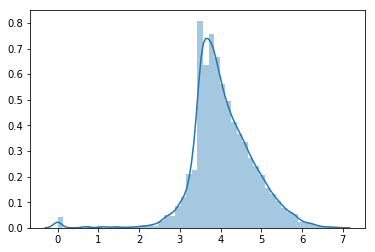

In [114]:
plt.show()

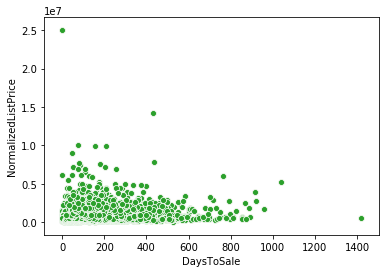

In [33]:
sns.scatterplot(x="DaysToSale", y="NormalizedListPrice", data = df_noNA)
plt.show()

In [37]:
sns.PairGrid(df_noNA[['DaysToSale','NormalizedListPrice','BuildingAreaSqFt',
                      'LotSizeSquareFeet','NoOfStories', 'TotalBedrooms','NormalizedBathCount',
                      'LandAssessedValue','TotalAssessedValue','built_prct','YearBuilt'
                     ]]).map(plt.scatter)
#plt.show()

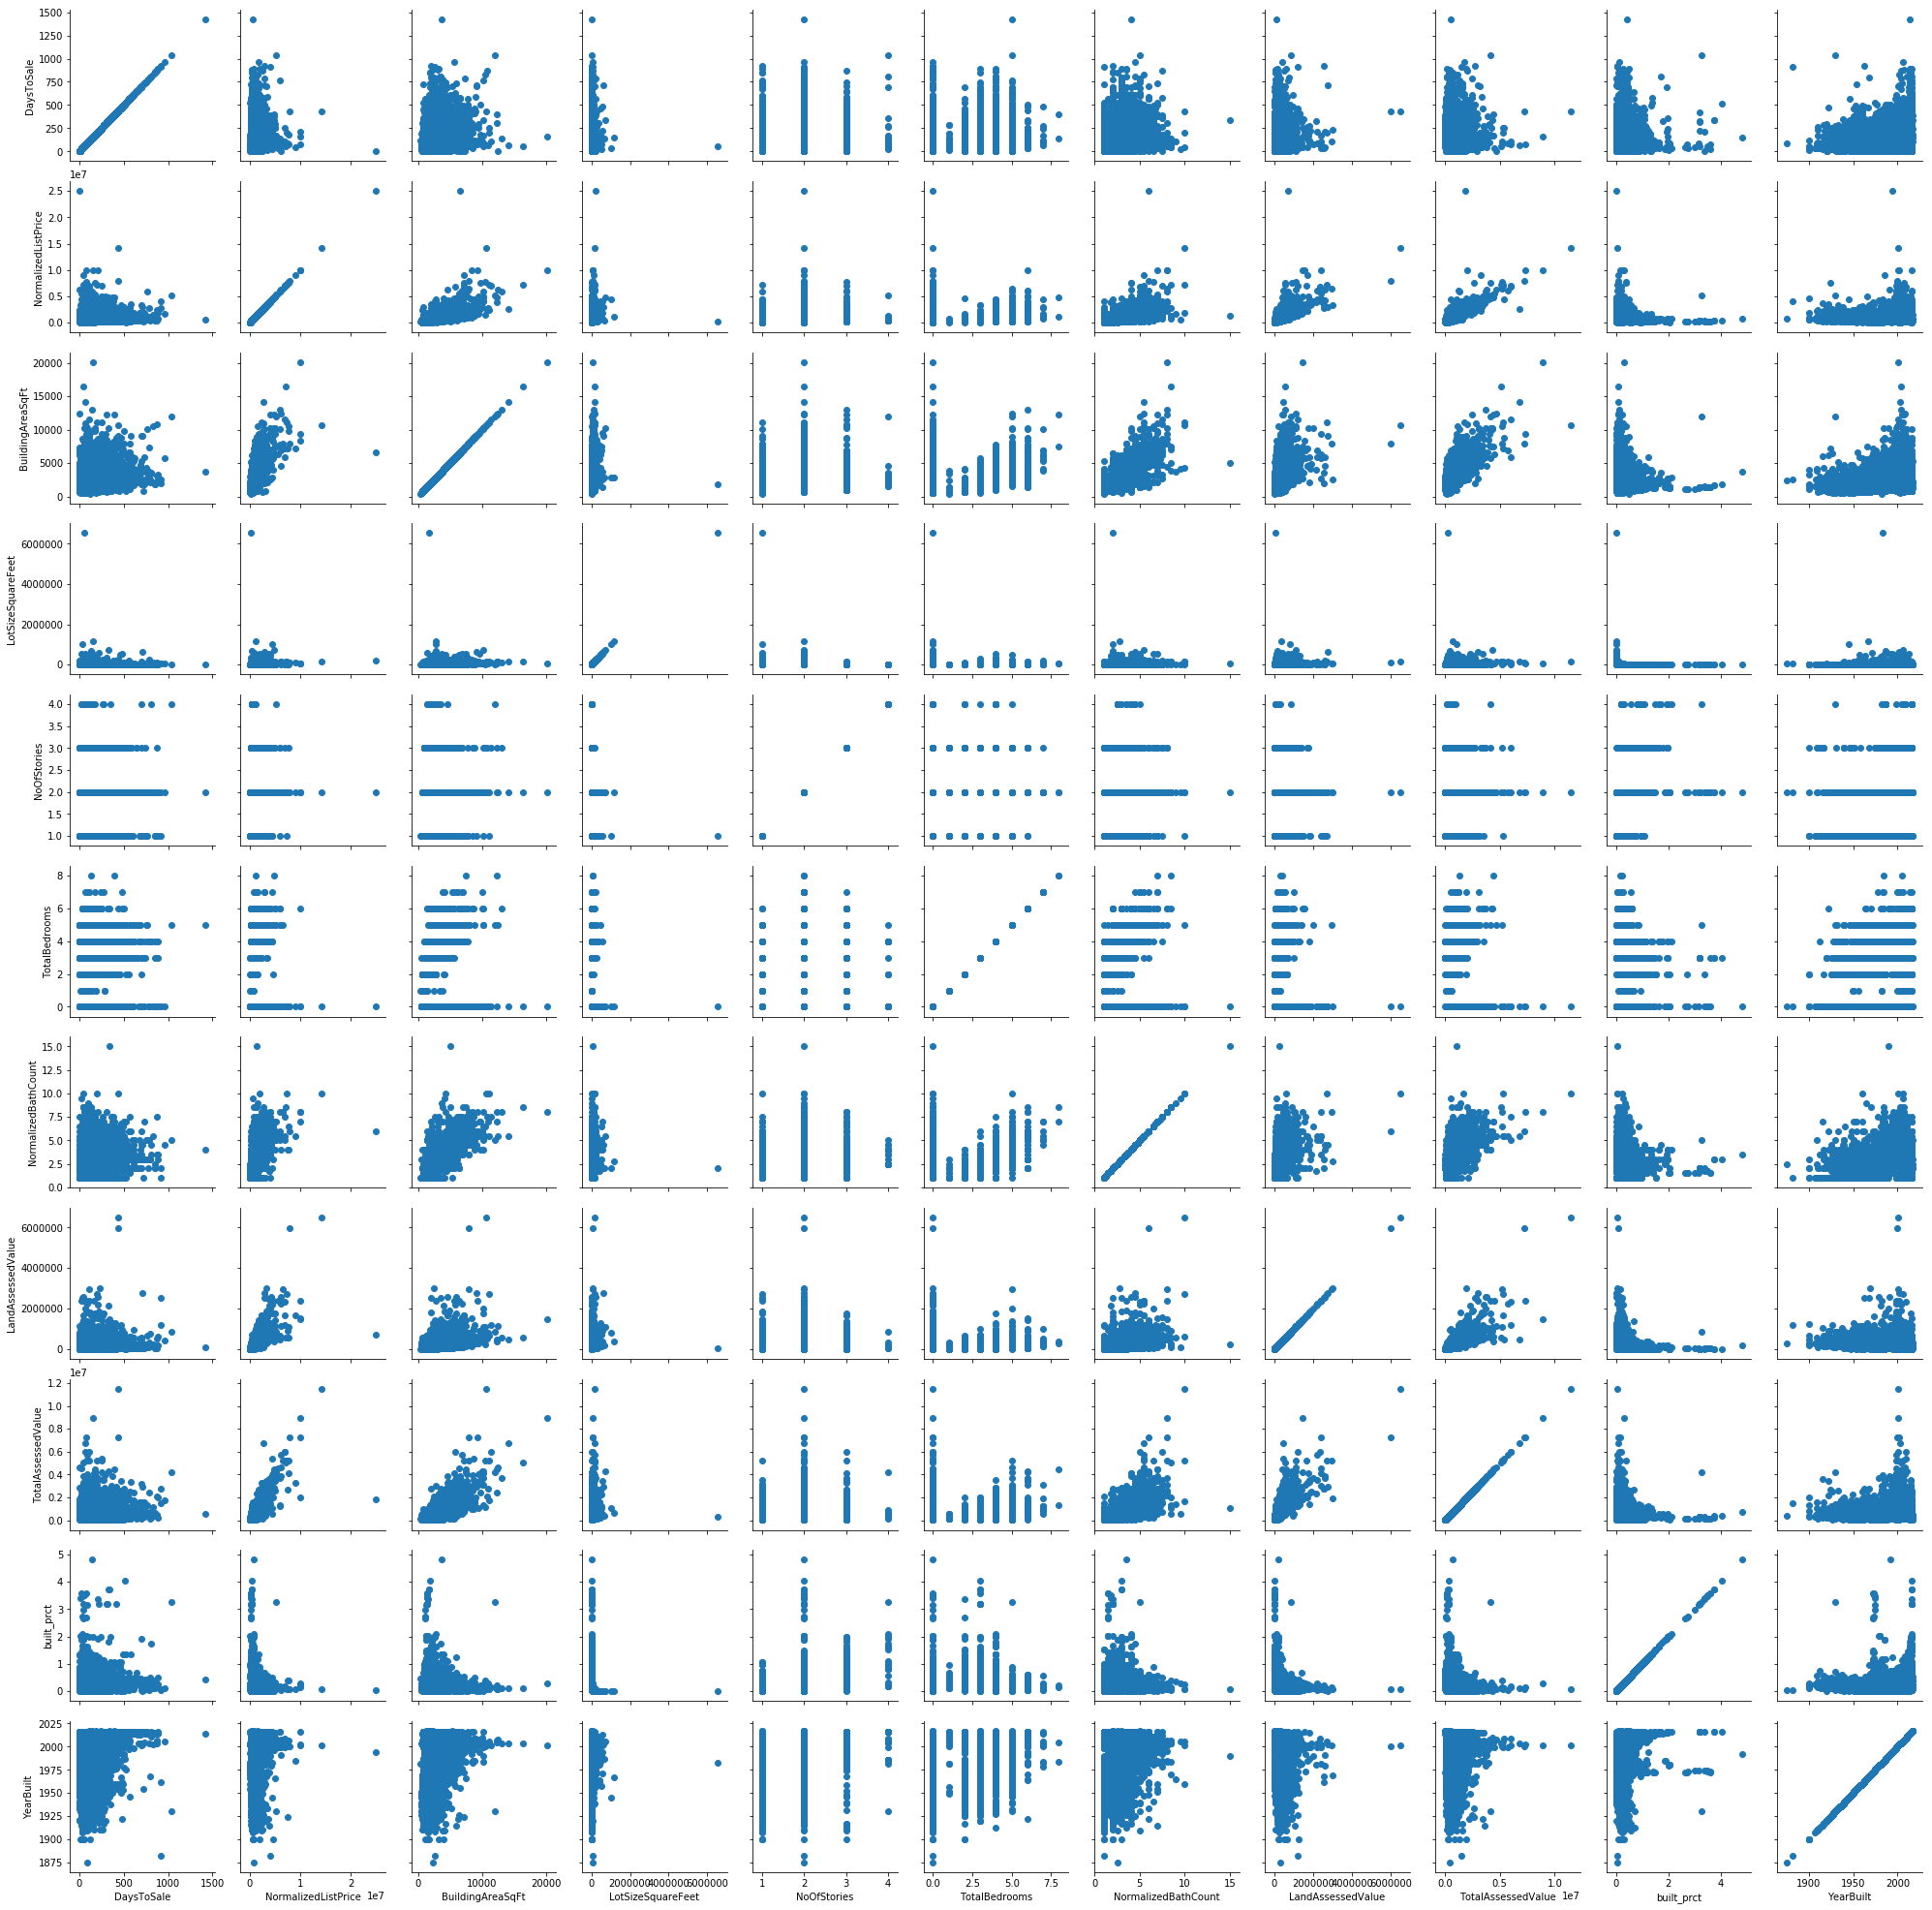

In [38]:
plt.show()

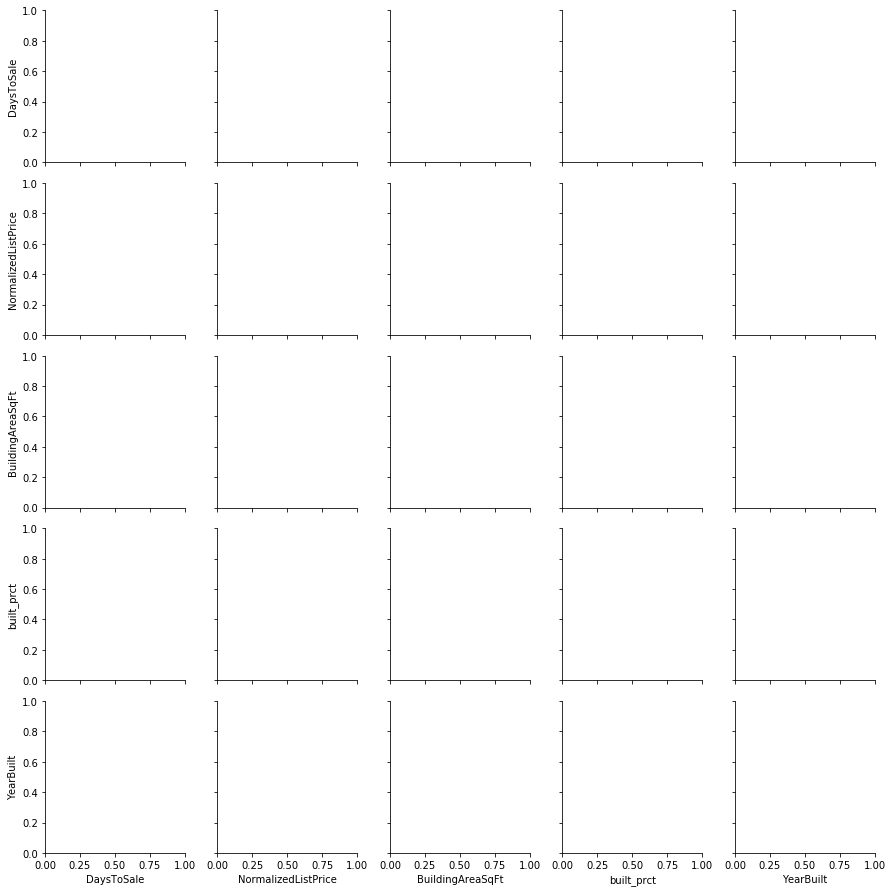

In [35]:
sns.PairGrid(df_noNA[['DaysToSale','NormalizedListPrice','BuildingAreaSqFt',
                      'built_prct','YearBuilt'
                     ]])
plt.show()

# ----- IN PROGRESS -- MAY NOT RUN -----

### Cross Validation

In [151]:
from hyperopt import hp, tpe, fmin, STATUS_OK

In [134]:
data_dmatrix = xgb.DMatrix(data=train_time_X,label=train_time_y)

In [188]:
N_FOLDS = 10

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Tuning"""
    
    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evalute based on ROC AUC

    print('Params: \n', params, '\n')
    cv_results = xgb.cv(dtrain = data_dmatrix, 
                        params = params,
                        nfold = n_folds, 
                        num_boost_round = 10000, 
                        early_stopping_rounds = 100, 
                        metrics = 'mae', 
                        as_pandas = True, 
                        seed = 50)
    
    # Extract the best score
    loss = min(cv_results['test-mae-mean'])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [189]:
# Define the search space

space = { 
            'colsample_bylevel':hp.uniform('colsample_bylevel', 0.0, 1.0),
            'colsample_bytree':hp.uniform('colsample_bytree', 0.0, 1.0), 
            'gamma':hp.uniform('gamma', 0, 100),
            'learning_rate':hp.uniform('learning_rate', 0.0, 1.0), 
            'max_depth':hp.choice('max_depth', np.arange(1,100, dtype=int)),
            'min_child_weight':hp.uniform('min_child_weight',0, 100), 
            'reg_alpha':hp.uniform('reg_alpha', 0, 1),
            'reg_lambda':hp.uniform('reg_lambda', 0, 1), 
            'subsample':hp.uniform('subsample', 0, 1)
        }
                                

In [147]:
tpe_algorithm =  tpe.suggest

In [184]:
data_dmatrix = xgb.DMatrix(data=train_reg_X,label=train_reg_y)

In [ ]:
MAX_EVALS = 100
best = fmin(fn = objective, space = space, algo = tpe.suggest,
            max_evals = MAX_EVALS
           )

Params:                                              

{'colsample_bylevel': 0.539529542551914, 'colsample_bytree': 0.6800915144963143, 'gamma': 33.91417420467665, 'learning_rate': 0.44861433335655554, 'max_depth': 95, 'min_child_weight': 20.89177141736107, 'reg_alpha': 0.8241519667404232, 'reg_lambda': 0.07157596639526975, 'subsample': 0.39350635435097203}
Params:                                                                  

{'colsample_bylevel': 0.3805400454036574, 'colsample_bytree': 0.8771470149012617, 'gamma': 43.71341799425706, 'learning_rate': 0.6948423663835257, 'max_depth': 39, 'min_child_weight': 36.84227423924008, 'reg_alpha': 0.6192064742862363, 'reg_lambda': 0.5888399998443546, 'subsample': 0.8007545500890911}
Params:                                                                  

{'colsample_bylevel': 0.19783620260853252, 'colsample_bytree': 0.04702578008814495, 'gamma': 16.574306489047817, 'learning_rate': 0.49641841456899516, 'max_depth': 44, 'min_child_weight':

Params:                                                                                

{'colsample_bylevel': 0.677810541696115, 'colsample_bytree': 0.321926236645201, 'gamma': 3.4181835187701206, 'learning_rate': 0.17129991578853504, 'max_depth': 10, 'min_child_weight': 1.7739425653561014, 'reg_alpha': 0.03548605118612215, 'reg_lambda': 0.28357553416734516, 'subsample': 0.993369892844477}
Params:                                                                                

{'colsample_bylevel': 0.42486198694886884, 'colsample_bytree': 0.3578558586518842, 'gamma': 0.22342518759761165, 'learning_rate': 0.21185942320342394, 'max_depth': 46, 'min_child_weight': 3.7375336795564174, 'reg_alpha': 0.03637837749309989, 'reg_lambda': 0.2921268112153946, 'subsample': 0.991662404670513}
Params:                                                                                

{'colsample_bylevel': 0.46126664279173984, 'colsample_bytree': 0.3496724375753665, 'gamma': 29.388459917701894, 'learnin

{'colsample_bylevel': 0.02806719272876168, 'colsample_bytree': 0.24128017639458854, 'gamma': 30.209453507983408, 'learning_rate': 0.5966557307852516, 'max_depth': 83, 'min_child_weight': 23.981788096034606, 'reg_alpha': 0.6878073726810028, 'reg_lambda': 0.5435368215912205, 'subsample': 0.806379941683762}
Params:                                                                     

{'colsample_bylevel': 0.618623408940331, 'colsample_bytree': 0.43711417147301007, 'gamma': 9.397955839656372, 'learning_rate': 0.19952178382912564, 'max_depth': 32, 'min_child_weight': 3.44784226520712, 'reg_alpha': 0.14076827890119795, 'reg_lambda': 0.29990421833859776, 'subsample': 0.9296484430968408}
Params:                                                                     

{'colsample_bylevel': 0.44536901321945854, 'colsample_bytree': 0.37255289361177824, 'gamma': 17.853238789641686, 'learning_rate': 0.08013982167518413, 'max_depth': 46, 'min_child_weight': 33.084639970642954, 'reg_alpha': 0.0377595288

Params:                                                                     

{'colsample_bylevel': 0.3149354499605058, 'colsample_bytree': 0.29398435299795295, 'gamma': 70.41586973289799, 'learning_rate': 0.15154074871087253, 'max_depth': 66, 'min_child_weight': 26.155387778729242, 'reg_alpha': 0.33097849231547405, 'reg_lambda': 0.12661917244618892, 'subsample': 0.5088280130289472}
Params:                                                                     

{'colsample_bylevel': 0.7127304052674794, 'colsample_bytree': 0.22830475992531646, 'gamma': 21.45470738313195, 'learning_rate': 0.09605612540425977, 'max_depth': 47, 'min_child_weight': 57.51847269284211, 'reg_alpha': 0.41108733399442765, 'reg_lambda': 0.5484153323510311, 'subsample': 0.45762872098960616}
Params:                                                                     

{'colsample_bylevel': 0.11438895149350631, 'colsample_bytree': 0.7531518932597185, 'gamma': 42.084023108112326, 'learning_rate': 0.029283923492023467, 

In [ ]:
best

In [174]:
best['booster'] = 'gbtree'

In [181]:
cv_results = xgb.cv(dtrain = data_dmatrix, 
                    params = best,
                    nfold = 10, 
                    num_boost_round = 10000, 
                    early_stopping_rounds = 100, 
                    metrics = 'mae', 
                    as_pandas = True, 
                    seed = 50)

In [182]:
cv_results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,0.452870,0.000925,0.452882,0.009519
1,0.420984,0.001148,0.420978,0.007645
